In [2]:
# Setting up the environment 
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style

style.use('ggplot')

In [3]:
# Filepath
path = r"C:\Users\david\OneDrive\Documents\Finance Data-Trip\jpm_income_statement_quarter.csv"
data = pd.read_csv(path, index_col='date', usecols=[0,1])
data.head()

,revenue
date,
2022-09-30,32716000000
2022-06-30,30709000000
2022-03-31,30718000000
2021-12-31,29288000000
2021-09-30,29661000000


<ipython-input-4-f14d187cd23f>:18: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(4)


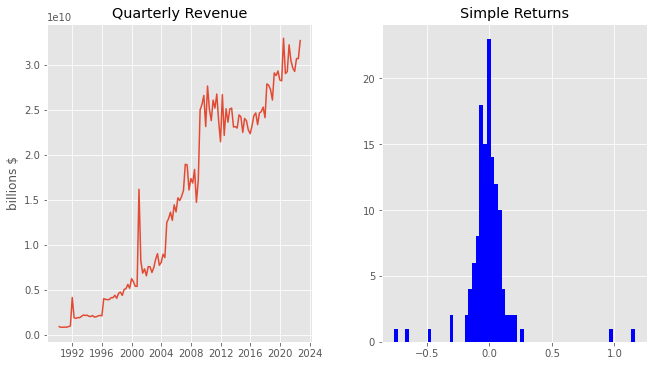

In [4]:
plt.subplots(figsize=(10,6))

# Time-series plot
data.index = pd.to_datetime(data.index)
plt.subplot(1,2,1)
plt.plot(data)
plt.title('Quarterly Revenue')
plt.ylabel('billions $')

#

# Histogram
returns = data.revenue.pct_change() #.dropna()
plt.subplot(1,2,2)
plt.hist(returns, bins=65, color='b')
plt.title('Simple Returns')

plt.tight_layout(4)

In [5]:
returns.describe() # how can the mean be negative if revenue keeps growing????

count    130.000000
mean      -0.008259
std        0.187691
min       -0.761262
25%       -0.064555
50%       -0.006711
75%        0.044391
max        1.165714
Name: revenue, dtype: float64

In [6]:
log_returns = np.log(data.revenue/data.revenue.shift(1)).dropna()
log_returns.describe()

count    130.000000
mean      -0.027404
std        0.210781
min       -1.432387
25%       -0.066733
50%       -0.006734
75%        0.043434
max        0.772750
Name: revenue, dtype: float64

In [7]:
# Parameters for simulation
num_sim = 1000 # more
num_periods = 8

simulation_df = pd.DataFrame()

# Running the simulation
for x in range(num_sim):
    count = 0
    last_rev = data.revenue[0]
    mean_return = returns.mean()
    st_dev = returns.std()

    forecast_series = [] 

    rev_proj = last_rev * (1 + np.random.normal(mean_return, st_dev)) # is this actually the appropriate distribution?
    forecast_series.append(rev_proj)  

    for y in range(num_periods):
        if count == num_periods - 1: # Part of me wants this to be 8. Looks better on the chart, but creates 9 rows in the df
            break
        rev_proj = forecast_series[count] * (1 + np.random.normal(mean_return, st_dev)) 
        forecast_series.append(rev_proj) 
        count += 1

    simulation_df[x] = forecast_series

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

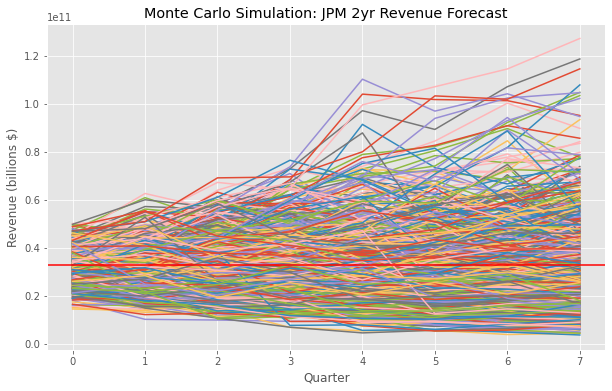

In [8]:
plt.figure(figsize=(10,6))
plt.plot(simulation_df)
plt.title('Monte Carlo Simulation: JPM 2yr Revenue Forecast')
plt.axhline(y = last_rev, color = 'r', linestyle = '-')
plt.xlabel('Quarter')
plt.ylabel('Revenue (billions $)')
plt.show()

# should I be using log returns?
# maybe I should use a list for the x-axis that would be more descriptive (and could start at 1)
#   ^  If I used a list, how would I make it match the steps of the simulation?
# the simulation seems to have automatically bounded itself at zero. Why? Can I double check it?

In [9]:
simulation_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,2.698502e+10,2.933324e+10,2.628164e+10,3.699939e+10,2.950009e+10,2.749637e+10,2.923675e+10,3.134300e+10,2.297369e+10,3.685798e+10,...,4.690372e+10,3.605224e+10,2.457459e+10,3.485322e+10,4.310454e+10,3.092248e+10,4.165373e+10,2.488883e+10,2.600878e+10,2.311093e+10
1,3.495331e+10,2.993501e+10,2.331280e+10,2.841943e+10,2.096895e+10,2.948117e+10,2.760024e+10,4.317503e+10,2.071512e+10,3.287039e+10,...,4.801249e+10,3.510373e+10,2.310396e+10,3.720420e+10,5.534699e+10,2.797076e+10,2.487036e+10,2.704451e+10,2.842475e+10,2.165851e+10
2,2.884553e+10,3.680263e+10,2.973177e+10,1.991817e+10,1.980461e+10,3.151093e+10,2.849818e+10,4.013594e+10,2.527004e+10,2.347930e+10,...,5.843788e+10,2.651391e+10,2.662553e+10,3.225560e+10,4.490649e+10,2.508070e+10,2.207454e+10,3.581507e+10,1.936237e+10,2.473291e+10
3,3.228740e+10,4.157999e+10,1.865322e+10,1.872757e+10,1.711872e+10,3.267570e+10,3.429756e+10,4.052315e+10,2.588100e+10,1.975723e+10,...,4.444206e+10,2.678651e+10,2.282947e+10,3.588807e+10,4.093719e+10,3.152371e+10,2.684109e+10,2.978289e+10,2.552114e+10,3.291150e+10
4,2.613642e+10,4.381709e+10,1.804437e+10,1.132873e+10,1.962250e+10,3.012114e+10,3.815495e+10,3.567015e+10,2.005990e+10,1.742643e+10,...,4.102691e+10,2.835702e+10,1.384450e+10,2.664933e+10,3.720674e+10,2.911185e+10,3.139338e+10,1.846907e+10,2.059506e+10,2.477739e+10
5,2.184398e+10,3.267806e+10,1.926313e+10,1.330226e+10,2.062888e+10,3.228883e+10,4.286288e+10,3.352174e+10,2.570769e+10,1.689056e+10,...,4.088264e+10,2.716130e+10,1.366869e+10,3.510304e+10,4.347212e+10,2.334314e+10,1.924514e+10,1.981590e+10,2.557824e+10,2.638697e+10
6,1.633520e+10,2.262698e+10,1.847661e+10,1.173572e+10,2.982829e+10,3.048153e+10,3.065817e+10,4.455882e+10,2.743508e+10,1.784987e+10,...,4.625525e+10,2.996518e+10,1.610302e+10,3.985627e+10,3.950389e+10,2.284378e+10,2.130003e+10,2.001257e+10,2.078724e+10,2.893766e+10
7,1.930146e+10,2.759215e+10,1.672019e+10,9.204398e+09,2.928289e+10,3.068264e+10,3.229228e+10,4.384186e+10,3.160237e+10,2.262149e+10,...,4.601390e+10,2.600487e+10,1.684711e+10,3.867710e+10,3.958865e+10,2.066616e+10,2.078564e+10,2.050040e+10,2.556869e+10,1.804074e+10


In [10]:
simulation_df.T.describe()

'''
weird things to note:
    - the mean value in the last quarter < last_rev
    - the upside gets really high (140,432,900,000), but the lowest value never drops below 1,998,370,000
'''


'\nweird things to note:\n    - the mean value in the last quarter < last_rev\n    - the upside gets really high (140,432,900,000), but the lowest value never drops below 1,998,370,000\n'